In [6]:
# Import necessary libraries
import os
import gc
import torch
import pandas as pd
from utils.dataUtils import DataUtils
from utils.modelUtils import ModelUtils
from utils.limeUtils import LIMEUtils
from utils.graphUtils import create_and_save_graph, draw_cluster_graph, draw_soi
from utils.soiUtils import SOIUtils
from utils.ragUtils import RAGUtils
from transformers import AutoTokenizer, AutoModelForCausalLM

# Parameters
dataset_name = 'manjuvallayil/factver_master'
model_name = 'MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'
embedding_model_name = 'sentence-transformers/all-mpnet-base-v2'
llama_model_name = 'meta-llama/Llama-2-7b-chat-hf'

selected_claim_id = 'Claim_59'
similarity_threshold = 0.75  # delta for cosine similarity
alpha = 0.5  # para for weighted vector combination of thematic embedding (1 for RAG only)
n_docs = 6  # number of docs to retrieve by RAG
n_components= 10 # number of clusters to from through gmm-em

# Paths for RAGUtils
passages_path = '/home/qsh5523/Documents/factver_dev/dataset'
index_path = '/home/qsh5523/Documents/factver_dev/faiss/index.faiss'

# Initialize LLaMA model
llama_tokenizer = AutoTokenizer.from_pretrained(llama_model_name)
llama_model = AutoModelForCausalLM.from_pretrained(llama_model_name)

# Initialize utilities
data_utils = DataUtils(dataset_name)
model_utils = ModelUtils(model_name, embedding_model_name)
lime_utils = LIMEUtils(model_utils)
soi_utils = SOIUtils(model_utils)
rag_utils = RAGUtils(passages_path, index_path, embedding_model_name)
"""
# Function to generate LLM-based explanation
def generate_llm_summary(claim, evidences):
    # Clear the GPU cache first
    gc.collect()
    torch.cuda.empty_cache()
    combined_evidence = ' '.join([evidence for evidence in evidences])
    prompt = f"Claim: {claim}\nEvidence: {combined_evidence}\nYou are a fact verification assistant. From the given Claim and its Evidence, determine if the claim is supported by the evidence and generate a concise explanation (two sentences max)."
    
    with torch.no_grad():
        inputs = llama_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
        outputs = llama_model.generate(inputs['input_ids'], max_new_tokens=200)
    
    return llama_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

# Load data without theme-based filtering
grouped_data = data_utils.get_full_data(selected_claim_id)

# GMM-EM Clustering
# Check if data is available
if grouped_data.empty:
    print("No data found in the dataset.")
else:
    # Get embeddings
    all_texts = [row['Claim_text'] for _, row in grouped_data.iterrows()]
    for _, row in grouped_data.iterrows():
        all_texts.extend(row['Evidence_text'])

    embeddings = model_utils.get_sent_embeddings(all_texts)

    # Apply GMM-EM clustering to dataset
    labels = model_utils.cluster_embeddings(embeddings, n_components)
    unique_labels = set(labels)
    print(f"Unique clusters identified in the dataset: {unique_labels}")

    # Draw and save cluster graph
    graph_filepath = 'graph.pkl'
    create_and_save_graph(model_utils, grouped_data, graph_filepath)

    #for cluster_id in unique_labels:
        #draw_cluster_graph(grouped_data, labels, cluster_id=cluster_id, model_utils=model_utils, title=f'Cluster Visualization {cluster_id}')

    # Ensure the selected claim is in the identified cluster
    selected_cluster_id = None
    claim_text = None

    for index, row in grouped_data.iterrows():
        unique_id = row['Claim_topic_id'].split('_')[-1]
        if f"Claim_{unique_id}" == selected_claim_id:
            selected_cluster_id = labels[index]
            claim_text = row['Claim_text']
            break

    if selected_cluster_id is not None:
        print(f"The selected claim ({selected_claim_id}) belongs to cluster {selected_cluster_id}")

        # Compare RAG (alpha=1.0) vs CARAG_U (alpha=0.5)

        # 1. RAG-based retrieval and explanation
        rag_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, aggregated_embedding=None, alpha=1.0)
        rag_explanation = generate_llm_summary(claim_text, rag_evidence)
        print("\nRAG Explanation:\n", rag_explanation)
        
        # Compute the SOI using CARAG_U
        soi = soi_utils.compute_soi_carag_u(selected_claim_id, grouped_data, labels, selected_cluster_id, similarity_threshold)
        soi_evidences = soi['refined_cluster_evidences']
        #draw_soi(soi, similarity_threshold, title=f'SOI Visualization for {selected_claim_id}')

        # Compute aggregated embedding for the SOI evidences
        aggregated_embedding = rag_utils.compute_aggregated_embedding([evidence for evidence, _ in soi_evidences])
        
        # 2. Generate explanation using CARAG_U (retrieved evidence with combined embedding)
        agg_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, aggregated_embedding, alpha=0.5)
        carag_u_explanation = generate_llm_summary(claim_text, agg_evidence)
        print("\nCARAG_U Explanation:\n", carag_u_explanation)
    
    else:
        print(f"Selected claim {selected_claim_id} is not part of any identified cluster.")

"""

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda
INFO:root:Classification model loaded on CUDA
/home/qsh5523/miniconda3/envs/factver_env/lib/python3.10/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning:

Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class

'\n# Function to generate LLM-based explanation\ndef generate_llm_summary(claim, evidences):\n    # Clear the GPU cache first\n    gc.collect()\n    torch.cuda.empty_cache()\n    combined_evidence = \' \'.join([evidence for evidence in evidences])\n    prompt = f"Claim: {claim}\nEvidence: {combined_evidence}\nYou are a fact verification assistant. From the given Claim and its Evidence, determine if the claim is supported by the evidence and generate a concise explanation (two sentences max)."\n    \n    with torch.no_grad():\n        inputs = llama_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)\n        outputs = llama_model.generate(inputs[\'input_ids\'], max_new_tokens=200)\n    \n    return llama_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()\n\n# Load data without theme-based filtering\ngrouped_data = data_utils.get_full_data(selected_claim_id)\n\n# GMM-EM Clustering\n# Check if data is available\nif grouped_data.empty:\n    print("No data f

In [38]:
# Import necessary libraries
import os
import gc
import torch
import pandas as pd
from utils.dataUtils import DataUtils
from utils.modelUtils import ModelUtils
from utils.limeUtils import LIMEUtils
from utils.graphUtils import create_and_save_graph, draw_cluster_graph, draw_soi
from utils.soiUtils import SOIUtils
from utils.ragUtils import RAGUtils
from transformers import AutoTokenizer, AutoModelForCausalLM

# Parameters
dataset_name = 'manjuvallayil/factver_master'
model_name = 'MoritzLaurer/DeBERTa-v3-base-mnli-fever-anli'
embedding_model_name = 'sentence-transformers/all-mpnet-base-v2'
llama_model_name = 'meta-llama/Llama-2-7b-chat-hf'

selected_claim_id = 'Claim_1'
similarity_threshold = 0.75  # delta for cosine similarity
alpha = 0.5  # parameter for weighted vector combination of thematic embedding
n_docs = 6  # number of docs to retrieve by RAG
n_components_carag = 3  # number of clusters for CARAG
n_components_carag_u = 10  # number of clusters for CARAG-U

# Paths for RAGUtils
passages_path = '/home/qsh5523/Documents/factver_dev/dataset'
index_path = '/home/qsh5523/Documents/factver_dev/faiss/index.faiss'

# Initialize LLaMA model
llama_tokenizer = AutoTokenizer.from_pretrained(llama_model_name)
llama_model = AutoModelForCausalLM.from_pretrained(llama_model_name)

# Initialize utilities
data_utils = DataUtils(dataset_name)
model_utils = ModelUtils(model_name, embedding_model_name)
lime_utils = LIMEUtils(model_utils)
soi_utils = SOIUtils(model_utils)
rag_utils = RAGUtils(passages_path, index_path, embedding_model_name)

# Function to generate LLM-based explanation
def generate_llm_summary(claim, evidences):
    # Clear the GPU cache first
    gc.collect()
    torch.cuda.empty_cache()
    combined_evidence = ' '.join([evidence for evidence in evidences])
    prompt = f"Claim: {claim}\nEvidence: {combined_evidence}\nYou are a fact verification assistant. From the given Claim and its Evidence, determine if the claim is supported by the evidence and generate a concise explanation (two sentences max)."
    
    with torch.no_grad():
        inputs = llama_tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)
        outputs = llama_model.generate(inputs['input_ids'], max_new_tokens=200)
    
    return llama_tokenizer.decode(outputs[0], skip_special_tokens=True).strip()



# Load themed data
theme, themed_data = data_utils.filter_by_theme(selected_claim_id)

# CARAG: Themed data clustering
if not themed_data.empty:
    # Get embeddings for themed data
    all_texts = [row['Claim_text'] for _, row in themed_data.iterrows()]
    for _, row in themed_data.iterrows():
        all_texts.extend(row['Evidence_text'])
    
    embeddings = model_utils.get_sent_embeddings(all_texts)
    
    # Apply GMM-EM clustering to themed data
    labels_carag = model_utils.cluster_embeddings(embeddings, n_components=n_components_carag)
    unique_labels_carag = set(labels_carag)
    print(f"Unique clusters identified within the theme {theme}: {unique_labels_carag}")

    # Ensure the selected claim is in the identified cluster
    selected_cluster_id_carag = None
    claim_text = None

    for index, row in themed_data.iterrows():
        unique_id = row['Claim_topic_id'].split('_')[-1]
        if f"Claim_{unique_id}" == selected_claim_id:
            selected_cluster_id_carag = labels_carag[index]
            claim_text = row['Claim_text']
            break

    if selected_cluster_id_carag is not None:
        print(f"The selected claim ({selected_claim_id}) belongs to cluster {selected_cluster_id_carag}")

        # 1. RAG-based retrieval and explanation (AS BASELINE)
        rag_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, aggregated_embedding=None, alpha=1.0)
        rag_explanation = generate_llm_summary(claim_text, rag_evidence)
        print("\nRAG Explanation:\n", rag_explanation)
        
        # 2. CARAG-based retrieval and explanation
        carag_soi = soi_utils.compute_soi(selected_claim_id, themed_data, labels_carag, selected_cluster_id_carag, similarity_threshold)
        carag_soi_evidences = carag_soi['related_claims'] + carag_soi['annotated_evidences'] + carag_soi['thematic_cluster_evidences']

        # Compute aggregated embedding for CARAG SOI
        carag_aggregated_embedding = rag_utils.compute_aggregated_embedding([evidence for evidence, _ in carag_soi_evidences])
        
        # Retrieve evidence using CARAG's SOI-based embedding
        carag_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, carag_aggregated_embedding, alpha=0.5)
        carag_explanation = generate_llm_summary(claim_text, carag_evidence)
        print("\nCARAG Explanation:\n", carag_explanation)
    else:
        print(f"Selected claim {selected_claim_id} is not part of any identified cluster in CARAG.")

else:
    print(f"No data found for the theme of claim {selected_claim_id}.")

#claim_text = 'New Zealand has a carbon trading system'
# CARAG-U: Dataset-wide clustering
grouped_data = data_utils.get_full_data(selected_claim_id)

if not grouped_data.empty:
    # Get embeddings for dataset-wide clustering
    all_texts = [row['Claim_text'] for _, row in grouped_data.iterrows()]
    for _, row in grouped_data.iterrows():
        all_texts.extend(row['Evidence_text'])
    
    embeddings = model_utils.get_sent_embeddings(all_texts)
    
    # Apply GMM-EM clustering to the full dataset
    labels_carag_u = model_utils.cluster_embeddings(embeddings, n_components=n_components_carag_u)
    unique_labels_carag_u = set(labels_carag_u)
    print(f"Unique clusters identified in the dataset: {unique_labels_carag_u}")

    # Ensure the selected claim is in the identified cluster
    selected_cluster_id_carag_u = None

    for index, row in grouped_data.iterrows():
        unique_id = row['Claim_topic_id'].split('_')[-1]
        if f"Claim_{unique_id}" == selected_claim_id:
            selected_cluster_id_carag_u = labels_carag_u[index]
            break

    if selected_cluster_id_carag_u is not None:
        print(f"The selected claim ({selected_claim_id}) belongs to cluster {selected_cluster_id_carag_u}")

        # 3. CARAG-U-based retrieval and explanation
        carag_u_soi = soi_utils.compute_soi_carag_u(selected_claim_id, grouped_data, labels_carag_u, selected_cluster_id_carag_u, similarity_threshold)
        carag_u_soi_evidences = carag_u_soi['refined_cluster_evidences']

        # Compute aggregated embedding for CARAG-U SOI
        carag_u_aggregated_embedding = rag_utils.compute_aggregated_embedding([evidence for evidence, _ in carag_u_soi_evidences])
        
        # Retrieve evidence using CARAG-U's dataset-wide embedding
        carag_u_evidence = rag_utils.retrieve_evidence(claim_text, n_docs, carag_u_aggregated_embedding, alpha=0.5)
        carag_u_explanation = generate_llm_summary(claim_text, carag_u_evidence)
        print("\nCARAG_U Explanation:\n", carag_u_explanation)
    else:
        print(f"Selected claim {selected_claim_id} is not part of any identified cluster in CARAG-U.")

else:
    print("No data found in the dataset.")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2
INFO:sentence_transformers.SentenceTransformer:Use pytorch device: cuda
INFO:root:Classification model loaded on CUDA
/home/qsh5523/miniconda3/envs/factver_env/lib/python3.10/site-packages/transformers/models/bart/configuration_bart.py:179: UserWarning:

Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RagTokenizer'. 
The class this function is called from is 'DPRQuestionEncoderTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class


 The selected Claim belongs to the theme: Climate


Batches:   0%|          | 0/20 [00:00<?, ?it/s]

Unique clusters identified within the theme Climate: {0, 1, 2}
The selected claim (Claim_1) belongs to cluster 1

RAG Explanation:
 Claim: New Zealand has a carbon trading system
Evidence: In fact, the survey¡¯s authors cited other studies that noted parental hesitancy in Bangladesh (42.8 per cent), Taiwan (10.8 per cent) and Vietnam (11.8 per cent). In fact, the survey¡¯s authors cited other studies that noted parental hesitancy in Bangladesh (42.8 per cent), Taiwan (10.8 per cent) and Vietnam (11.8 per cent). An inquest at Dublin District Coroner’s Court heard a post-mortem on the body of Ms Kerry, a mother of seven from Cooleeney, Dublin Road, Longford, was inconclusive in establishing the cause of her death. An inquest at Dublin District Coroner’s Court heard a post-mortem on the body of Ms Kerry, a mother of seven from Cooleeney, Dublin Road, Longford, was inconclusive in establishing the cause of her death. Scientists warn that it is likely better at dodging immunity than others 

Batches:   0%|          | 0/2 [00:00<?, ?it/s]


CARAG Explanation:
 Claim: New Zealand has a carbon trading system
Evidence: In fact, the survey¡¯s authors cited other studies that noted parental hesitancy in Bangladesh (42.8 per cent), Taiwan (10.8 per cent) and Vietnam (11.8 per cent). In fact, the survey¡¯s authors cited other studies that noted parental hesitancy in Bangladesh (42.8 per cent), Taiwan (10.8 per cent) and Vietnam (11.8 per cent). Scientists warn that it is likely better at dodging immunity than others based on lab tests of its grand-father BA.2.75. Scientists warn that it is likely better at dodging immunity than others based on lab tests of its grand-father BA.2.75. An inquest at Dublin District Coroner’s Court heard a post-mortem on the body of Ms Kerry, a mother of seven from Cooleeney, Dublin Road, Longford, was inconclusive in establishing the cause of her death. An inquest at Dublin District Coroner’s Court heard a post-mortem on the body of Ms Kerry, a mother of seven from Cooleeney, Dublin Road, Longford,

Batches:   0%|          | 0/116 [00:00<?, ?it/s]

Unique clusters identified in the dataset: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
The selected claim (Claim_1) belongs to cluster 8


Batches:   0%|          | 0/2 [00:00<?, ?it/s]


CARAG_U Explanation:
 Claim: New Zealand has a carbon trading system
Evidence: In fact, the survey¡¯s authors cited other studies that noted parental hesitancy in Bangladesh (42.8 per cent), Taiwan (10.8 per cent) and Vietnam (11.8 per cent). In fact, the survey¡¯s authors cited other studies that noted parental hesitancy in Bangladesh (42.8 per cent), Taiwan (10.8 per cent) and Vietnam (11.8 per cent). Charging infrastructure remains unevenly distributed and subject to supply issues - some charging stations were curtailed recently thanks to a fall in electricity production caused by the mega drought affecting parts of China. Scientists warn that it is likely better at dodging immunity than others based on lab tests of its grand-father BA.2.75. Scientists warn that it is likely better at dodging immunity than others based on lab tests of its grand-father BA.2.75. An inquest at Dublin District Coroner’s Court heard a post-mortem on the body of Ms Kerry, a mother of seven from Cooleeney

In [ ]:
from utils.dataUtils import DataUtils
from utils.modelUtils import ModelUtils
from utils.limeUtils import LIMEUtils
from utils.graphUtils import create_and_save_graph, draw_cluster_graph, draw_soi
from utils.soiUtils import SOIUtils
from utils.ragUtils import RAGUtils

# Parameters
#embedding_model_name = 'sentence-transformers/all-mpnet-base-v2'

# Paths for RAGUtils
#passages_path = '/home/qsh5523/Documents/factver_dev/dataset'
#index_path = '/home/qsh5523/Documents/factver_dev/faiss/index.faiss'

import numpy as np
import pandas as pd

# Initialize utilities
#rag_utils = RAGUtils(passages_path, index_path, embedding_model_name)


# Load dataset and global vectors
dataset_vectors = rag_utils.load_dataset_vectors()  # Global context vectors
print(f"Loaded {len(dataset_vectors)} vectors from the FAISS index.")

# Load the data from the CSV file
data_path = 'results.csv'
df = pd.read_csv(data_path)

# Check for available themes in results.csv
themes = df['Theme'].unique() if 'Theme' in df.columns else []
print(f"Available themes in results.csv: {themes}")

# Step 1: Extract claim IDs and explanations
# Uncomment the line below to filter for a specific theme (e.g., Climate, Covid, Electric_Vehicles)
#df = df[df['Theme'] == 'Climate']
claim_ids = df['Claim_id'].tolist()
annotated_explanations = df['Annotated'].tolist()
rag_explanations = df['RAG'].tolist()
carag_explanations = df['CARAG'].tolist()
carag_u_explanations = df['CARAG_U'].tolist()  # New column for CARAG_U explanations

# Define function for generating embeddings
def generate_explanation_embeddings(explanations, model_utils):
    explanation_embeddings = model_utils.get_sent_embeddings(explanations)
    return np.atleast_2d(explanation_embeddings)  # Ensure the embeddings are 2D

# Generate embeddings for explanations
annotated_embeddings = generate_explanation_embeddings(annotated_explanations, model_utils)
rag_embeddings = generate_explanation_embeddings(rag_explanations, model_utils)
carag_embeddings = generate_explanation_embeddings(carag_explanations, model_utils)
carag_u_embeddings = generate_explanation_embeddings(carag_u_explanations, model_utils)  # Generate CARAG_U embeddings

# Generate themed data embeddings for each theme
themed_data_embeddings = {}
for theme in themes:
    themed_data = data_utils.themed_data(theme)
    if not themed_data.empty:
        # Flatten list of lists in `Evidence_text`
        valid_evidence_texts = themed_data['Evidence_text'].dropna().tolist()
        valid_evidence_texts_flat = [item for sublist in valid_evidence_texts for item in sublist if isinstance(item, str) and item.strip()]
        
        # Generate embeddings if valid evidence texts exist
        if valid_evidence_texts_flat:
            themed_vectors = model_utils.get_sent_embeddings(valid_evidence_texts_flat)
            themed_data_embeddings[theme] = themed_vectors
            print(f"Generated embeddings for theme '{theme}' with {len(themed_vectors)} vectors.")
        else:
            print(f"No valid evidence texts found for theme '{theme}'.")
    else:
        print(f"No data found for theme '{theme}'")

# Print CARAG_U embeddings for verification
print(f"Generated {len(carag_u_embeddings)} CARAG_U embeddings.")

Loaded 3102 vectors from the FAISS index.
Available themes in results.csv: ['Climate' 'Covid' 'Electric_Vehicles' nan]


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Generated embeddings for theme 'Climate' with 486 vectors.


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

Generated embeddings for theme 'Covid' with 2004 vectors.


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generated embeddings for theme 'Electric_Vehicles' with 606 vectors.
No data found for theme 'nan'
Generated 31 CARAG_U embeddings.


/tmp/ipykernel_988341/4213212557.py:80: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.

/tmp/ipykernel_988341/4213212557.py:100: UserWarning:

You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.



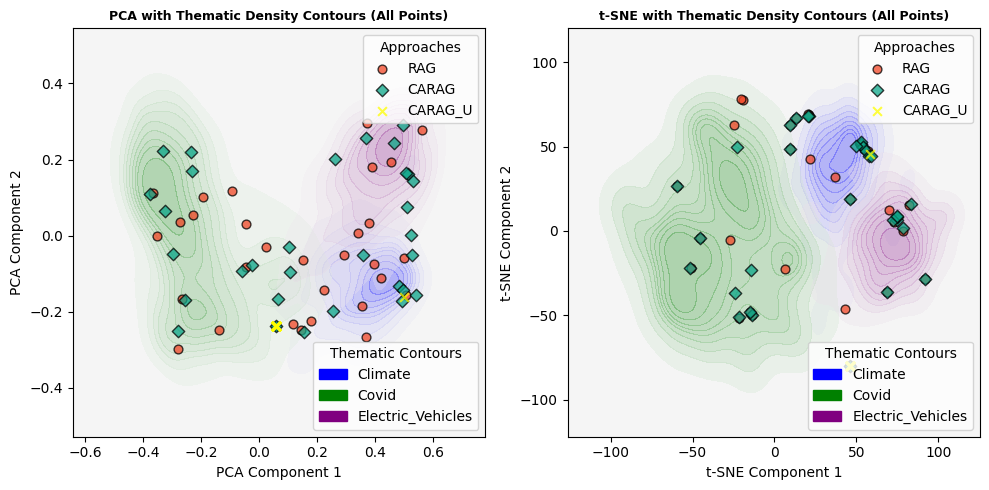

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

# Function to apply t-SNE
def apply_tsne(embeddings):
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # Ensure perplexity is less than n_samples
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    return tsne.fit_transform(embeddings)

# Apply PCA and t-SNE transformations to RAG, CARAG, CARAG_U, and themed embeddings
all_embeddings = np.vstack([rag_embeddings, carag_embeddings, carag_u_embeddings, *themed_data_embeddings.values()])
labels = (
    ['RAG'] * len(rag_embeddings)
    + ['CARAG'] * len(carag_embeddings)
    + ['CARAG_U'] * len(carag_u_embeddings)
    + sum([[theme] * len(vectors) for theme, vectors in themed_data_embeddings.items()], [])
)

# PCA transformation
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(all_embeddings)
rag_pca = pca_embeddings[:len(rag_embeddings)]
carag_pca = pca_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_pca = pca_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_pca = {
    theme: pca_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# t-SNE transformation
tsne_embeddings = apply_tsne(all_embeddings)
rag_tsne = tsne_embeddings[:len(rag_embeddings)]
carag_tsne = tsne_embeddings[len(rag_embeddings):len(rag_embeddings) + len(carag_embeddings)]
carag_u_tsne = tsne_embeddings[len(rag_embeddings) + len(carag_embeddings):len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)]
themed_tsne = {
    theme: tsne_embeddings[
        len(rag_embeddings) + len(carag_embeddings) + len(carag_u_embeddings)
        + sum(len(v) for k, v in list(themed_data_embeddings.items())[:i])
        :][:len(vectors)]
    for i, (theme, vectors) in enumerate(themed_data_embeddings.items())
}

# Define distinct colors for each theme and approach
theme_colors = {
    'Climate': 'blue',
    'Covid': 'green',
    'Electric_Vehicles': 'purple'
}
approach_colors = {
    'RAG': '#F24726',  # Red
    'CARAG': '#0CA789',  # Teal
    'CARAG_U': 'yellow'  # Blue
}

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5)) #figsize=(8, 4.25)

# PCA plot with separate thematic densities
for theme, color in theme_colors.items():
    if themed_pca[theme].shape[0] > 1:  # Ensure there are enough points for KDE
        sns.kdeplot(
            x=themed_pca[theme][:, 0],
            y=themed_pca[theme][:, 1],
            ax=axes[0],
            fill=True,
            cmap=sns.light_palette(color, as_cmap=True),
            alpha=0.3,
            label=f'{theme} Contour'
        )
axes[0].scatter(rag_pca[:, 0], rag_pca[:, 1], color=approach_colors['RAG'], edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[0].scatter(carag_pca[:, 0], carag_pca[:, 1], color=approach_colors['CARAG'], edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[0].scatter(carag_u_pca[:, 0], carag_u_pca[:, 1], color=approach_colors['CARAG_U'], edgecolor='black', label='CARAG_U', s=40, marker='x', alpha=0.75)
axes[0].set_title("PCA with Thematic Density Contours (All Points)", fontsize=9, fontweight='bold')
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")
axes[0].set_facecolor('#f5f5f5')

# t-SNE plot with separate thematic densities
for theme, color in theme_colors.items():
    if themed_tsne[theme].shape[0] > 1:  # Ensure there are enough points for KDE
        sns.kdeplot(
            x=themed_tsne[theme][:, 0],
            y=themed_tsne[theme][:, 1],
            ax=axes[1],
            fill=True,
            cmap=sns.light_palette(color, as_cmap=True),
            alpha=0.3,
            label=f'{theme} Contour'
        )
axes[1].scatter(rag_tsne[:, 0], rag_tsne[:, 1], color=approach_colors['RAG'], edgecolor='black', label='RAG', s=40, alpha=0.75)
axes[1].scatter(carag_tsne[:, 0], carag_tsne[:, 1], color=approach_colors['CARAG'], edgecolor='black', label='CARAG', s=40, marker='D', alpha=0.75)
axes[1].scatter(carag_u_tsne[:, 0], carag_u_tsne[:, 1], color=approach_colors['CARAG_U'], edgecolor='black', label='CARAG_U', s=40, marker='x', alpha=0.75)
axes[1].set_title("t-SNE with Thematic Density Contours (All Points)", fontsize=9, fontweight='bold')
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")
axes[1].set_facecolor('#f5f5f5')

# Add the first legend for scatter plot points
handles_points, labels_points = axes[0].get_legend_handles_labels()
scatter_legend = axes[0].legend(handles=handles_points, labels=labels_points, loc='upper right', title='Approaches')

# Add the second legend for thematic contours
theme_legend_patches = [mpatches.Patch(color=color, label=f"{theme}") for theme, color in theme_colors.items()]
contour_legend = axes[0].legend(handles=theme_legend_patches, loc='lower right', title='Thematic Contours')

# Add legends back manually
axes[0].add_artist(scatter_legend)

handles_points_tsne, labels_points_tsne = axes[1].get_legend_handles_labels()
scatter_legend_tsne = axes[1].legend(handles=handles_points_tsne, labels=labels_points_tsne, loc='upper right', title='Approaches')

contour_legend_tsne = axes[1].legend(handles=theme_legend_patches, loc='lower right', title='Thematic Contours')
axes[1].add_artist(scatter_legend_tsne)

plt.tight_layout()
plt.show()

# TRY 3D VISUALIZATIONS and DYNAMIC CLUSTERING

• Unsupervised Thematic Clustering  Use clustering techniques (e.g., GMM-EM) on the entire dataset embeddings to dynamically discover thematic clusters.  Cluster size (k) can be:  • Fixed by the user (e.g., 10 clusters by default).  

• Dynamically determined using methods like silhouette score or Bayesian Information Criterion (BIC).  Ensure clusters group semantically related texts, irrespective of labels or themes.  